# Practice 3: Validation

## Task 2

### importing the libraries and preprocessing the data

In [82]:
import os
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import nltk
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

In [83]:
%matplotlib inline

In [84]:
warnings.filterwarnings('ignore')

In [85]:
!pip install kaggle

In the following cell, upload the kaggle.json API file which will let us download the dataset

[How to create kaggle.json API file](https://www.kaggle.com/docs/api)

In [86]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"geraygench","key":"044426052610aea6df5ef6aaaa85b3ce"}'}

In [87]:
! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [88]:
! kaggle competitions download -c commonlit-evaluate-student-summaries

commonlit-evaluate-student-summaries.zip: Skipping, found more recently modified local copy (use --force to force download)


In [89]:
import zipfile
import os

# Specify the path to the zip archive
zip_file_path = 'commonlit-evaluate-student-summaries.zip'

# Specify the directory where you want to extract the files
extract_dir = 'commonlit_evaluate_student_summaries'

# Create the extract directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Open the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)

print("Zip archive extracted to", extract_dir)

Zip archive extracted to commonlit_evaluate_student_summaries


## Dataset Description

The dataset comprises about 24,000 summaries written by students in grades 3-12 of passages on a variety of topics and genres. These summaries have been assigned scores for both content and wording.

### File and Field Information

* summaries_train.csv - Summaries in the training set.
 * student_id - The ID of the student writer.
 * prompt_id - The ID of the prompt which links to the prompt file.
 * text - The full text of the student's summary.
 * content - The content score for the summary. The first target.
 * wording - The wording score for the summary. The second target.
* summaries_test.csv - Summaries in the test set. Contains all fields above except content and wording.
* prompts_train.csv - The four training set prompts. Each prompt comprises the complete summarization assignment given to students.
 * prompt_id - The ID of the prompt which links to the summaries file.
 * prompt_question - The specific question the students are asked to respond to.
 * prompt_title - A short-hand title for the prompt.
 * prompt_text - The full prompt text.
* prompts_test.csv - The test set prompts. Contains the same fields as above. The prompts here are only an example. The full test set has a large number of prompts. The train / public test / private test splits do not share any prompts.
*sample_submission.csv - A submission file in the correct format

In [90]:
# This is how a sample submission looks
df_samplesub=pd.read_csv("commonlit_evaluate_student_summaries/sample_submission.csv")
df_samplesub.head()

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [91]:
df_train_summ=pd.read_csv("commonlit_evaluate_student_summaries/summaries_train.csv")
print("Shape of df_train_text: ",df_train_summ.shape)
df_train_summ.head()

Shape of df_train_text:  (7165, 5)


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [92]:
df_train_summ.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


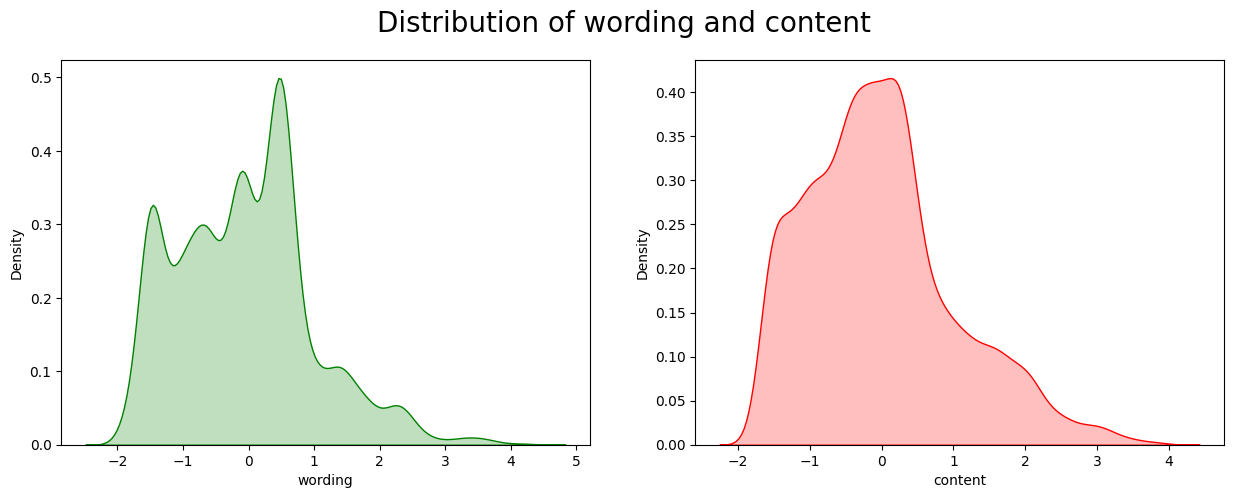

In [93]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches(15,5)
fig.suptitle("Distribution of wording and content", fontsize=20)
sns.kdeplot(df_train_summ['wording'], shade=True, ax=ax[0], color='green')
sns.kdeplot(df_train_summ['content'], shade=True, ax=ax[1], color='red')
fig.show()

In [94]:
df_train_prompts=pd.read_csv("commonlit_evaluate_student_summaries/prompts_train.csv")
print("Shape of df_test_p: ",df_train_prompts.shape)
df_train_prompts.head(1)

Shape of df_test_p:  (4, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...


In [95]:
df_test_summ=pd.read_csv("commonlit_evaluate_student_summaries/summaries_test.csv")
print("Shape of df_test_text: ",df_test_summ.shape)
df_test_summ.head()

Shape of df_test_text:  (4, 3)


,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [96]:
df_test_prompts=pd.read_csv("commonlit_evaluate_student_summaries/prompts_test.csv")
print("Shape of df_test_p: ",df_test_prompts.shape)
df_test_prompts.head()

Shape of df_test_p:  (2, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


We won't show the whole EDA pipeline here, as we focusing on the validation part. So, if you want to see the full EDA pipeline, please refer to [Practice1.ipynb](https://github.com/geeeeenccc/NLP-Course-IASA-Homework/blob/04f5305e6ca15393685ed71d647653a50a6332b6/Homework%201/Practice1.ipynb).

Anyway what we will do before getting to the validation part is to convert the text in the "text" column of your DataFrame to lowercase, and then replace any non-alphanumeric characters with a space.

In [97]:
# Let's do a text transformation

# Convert the text in the "text" column of  DataFrame to lowercase.
df_train_summ["transformed_text"]=df_train_summ.text.str.lower()
# Finally, use the re.sub() function to replace any non-alphanumeric characters with a space.
df_train_summ["transformed_text"]=df_train_summ["transformed_text"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
# Convert the text in the "text" column of  DataFrame to lowercase.
df_test_summ["transformed_text"]=df_test_summ.text.str.lower()
# Finally, use the re.sub() function to replace any non-alphanumeric characters with a space.
df_test_summ["transformed_text"]=df_test_summ["transformed_text"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

In [98]:
print("Transformed Text: ",df_train_summ["transformed_text"][0])

Transformed Text:  the third wave was an experimentto see how people reacted to a new one leader government it gained popularity as people wanted to try new things the students follow anything that is said and start turning on eachother to gain higher power they had to stop the experement as too many people got to radical with it blindly following there leader


In [99]:
nltk.download('stopwords')

stopwords=nltk.corpus.stopwords
stopwords=stopwords.words('english')

stopwords[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [100]:
# Some other feature engineering functions:
# 1. Total number of words
# 2. Number of stopwords
# 3. Number of punctuation
# 4. Number of numbers
# 5. Implement the feature engineering
def count_total_words(text: str) -> int:
    words = text.split()
    total_words = len(words)
    return total_words

def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords)
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

def feature_engineering(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: count_total_words(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [101]:
df_train_summ = feature_engineering(df_train_summ)
df_test_summ = feature_engineering(df_test_summ)

As we did in Practice 2, we will use the TfidfVectorizer to vectorize the text.

 Then we will concatenate the vectorized data with the training and test data.

And finally, after that, we can start working on the validation part.

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [103]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(encoding='utf-8',
                            #  tokenizer=word_tokenize,
                             ngram_range=(1, 1),
                             lowercase=True,
                             stop_words=stopwords,
                             max_features=250)

# Fit the vectorizer to the training data
train_vectorized = pd.DataFrame(
                vectorizer.fit_transform(df_train_summ['transformed_text']).toarray(),
                columns=[f"tfidf_{str(f)}" for f in vectorizer.get_feature_names_out()],
            )

# Fit the vectorizer to the test data
test_vectorized = pd.DataFrame(
                vectorizer.transform(df_test_summ['transformed_text']).toarray(),
                columns=[f"tfidf_{str(f)}" for f in vectorizer.get_feature_names_out()],
            )

In [104]:
# Copy the training and test data (just in case)
df_train_summ_copy = df_train_summ.copy()
df_test_summ_copy = df_test_summ.copy()

In [105]:
# concatenate the training and test data with their vectorized data
df_train_summ = pd.concat([df_train_summ, train_vectorized], axis=1)
df_test_summ = pd.concat([df_test_summ, test_vectorized], axis=1)

df_train_summ.head()

,student_id,prompt_id,text,content,wording,transformed_text,text_length,text_word_cnt,text_stopword_cnt,text_punct_cnt,...,tfidf_well,tfidf_whenever,tfidf_white,tfidf_whole,tfidf_work,tfidf_worked,tfidf_workers,tfidf_working,tfidf_would,tfidf_write
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,the third wave was an experimentto see how peo...,346,61,25,3,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,they would rub it up with soda to make the sme...,244,52,30,2,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.252892,0.0,0.425880,0.000000
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,in egypt there were many occupations and socia...,1370,235,98,38,...,0.090477,0.0,0.0,0.0,0.092157,0.0,0.091538,0.0,0.308306,0.117204
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,the highest class was pharaohs these people we...,157,25,11,6,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,the third wave developed rapidly because the s...,1225,203,92,30,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.159293,0.000000


In [106]:
# Selection of the features we will use to train the model
features = df_train_summ.drop(columns = ['student_id', 'prompt_id', 'text', 'transformed_text', 'content', 'wording'], axis = 1).columns

### Now let's take a look at the public discussions about validation for the "CommonLit - Evaluate Student Summaries" competition:

One common discussion point is whether to stratify the K-folds by prompt_id. This can help to ensure that each fold contains a representative sample of prompts. However, it is important to note that this can also lead to overfitting, as the model may learn the different prompts and be able to predict the scores more accurately on the held-out folds.

Another discussion point is whether to use regular K-fold cross-validation or Group K-fold cross-validation. Group K-fold cross-validation groups the data by prompt_id and then performs K-fold cross-validation on each group. This can help to reduce overfitting, as the model will not be able to learn the different prompts.

In [107]:
from sklearn.svm import SVR # import the SVR model
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold # import the KFold, StratifiedKFold and GroupKFold
from sklearn.metrics import mean_squared_error # import the MSE metric to calculate the RMSE
from sklearn.metrics import mean_absolute_error, r2_score # import the MAE and R2 metrics
import numpy as np

Submissions are scored using MCRMSE, mean columnwise root mean squared error:

\begin{equation}
\text{MCRMSE} = \frac{1}{N_t} \sum_{j=1}^{N_t} \sqrt{\frac{1}{n} \sum_{i=1}^n \left( \hat{y}_i - y_i \right)^2}
\end{equation}

where $N_{t}$ is the number of scored ground truth target columns, and ${y}$ and $\hat{y}$ are the actual and predicted values, respectively.

 And because it is used as submission evaluation metric, so to make correct comparison we should also use it to for local validation

### **K-fold**

We'll start with plain K-fold cross-validation


In [108]:
N_FOLDS = 10 # Number of folds in the cross-validation
# As in plain K-fold CV we won't stratify the data,
# we are able to use whatever amount of N_FOLDS we want

SEED = 42 # Random seed

Here what is going to happen is that we will loop through each target variable and perform K-fold cross-validation.

In [109]:
# List of target variables
target_variables = ['content', 'wording']

# Initialize a list to store RMSE values for each fold
rmse_values_content = []
rmse_values_wording = []
mcrmse_values = []

# we might also want to store MAE and R2 values for each fold
mae_values = []
r2_values = []

# Loop through each target variable
for target in target_variables:
    X, y = df_train_summ[features], df_train_summ[target]
    X_test = df_test_summ[features]
    y_test = np.zeros(shape=df_test_summ.shape[0], dtype=float)

    # Define K-Fold cross-validation
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

    # Train loop
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"| Target: {target} - Fold {idx+1} |".center(80, "-"))
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        print(f'train: {X_train.shape}')
        print(f'val: {X_val.shape}')

        # Initialize and train the SVR model
        # Some params explained:
        # degree defines the degree of the polynomial kernel function
        # Epsilon defines the width of the margin,
        # and C controls the trade-off between maximizing the margin and minimizing the error.
        model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

        model.fit(X_train, y_train)

        # Make predictions on the validation set
        y_pred_val = model.predict(X_val)

        # Calculate RMSE for the validation set
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
        mae_val = mean_absolute_error(y_val, y_pred_val)
        r2_val = r2_score(y_val, y_pred_val)
        print(f"Validation RMSE: {rmse_val}")
        print('Other metrics...')
        print(f"MAE: {mae_val}")
        print(f"R2: {r2_val}")
        # Append RMSE to the list

        if target == 'content':
            rmse_values_content.append(rmse_val)
        elif target == 'wording':
            rmse_values_wording.append(rmse_val)

        mae_values.append(mae_val)
        r2_values.append(r2_val)

        # Make predictions on the test data
        y_test += model.predict(X_test) / N_FOLDS

    # Store predictions in the DataFrame
    df_samplesub[target] = y_test


--------------------------| Target: content - Fold 1 |--------------------------
train: (6448, 255)
val: (717, 255)
Validation RMSE: 0.5213271205853123
Other metrics...
MAE: 0.39361412828538855
R2: 0.7494590514716406
--------------------------| Target: content - Fold 2 |--------------------------
train: (6448, 255)
val: (717, 255)
Validation RMSE: 0.5248900344062588
Other metrics...
MAE: 0.38634852383111673
R2: 0.753007842433432
--------------------------| Target: content - Fold 3 |--------------------------
train: (6448, 255)
val: (717, 255)
Validation RMSE: 0.5472463225910047
Other metrics...
MAE: 0.4081067543944954
R2: 0.7431024766761534
--------------------------| Target: content - Fold 4 |--------------------------
train: (6448, 255)
val: (717, 255)
Validation RMSE: 0.5505979319815802
Other metrics...
MAE: 0.39918585309196447
R2: 0.7188494074513656
--------------------------| Target: content - Fold 5 |--------------------------
train: (6448, 255)
val: (717, 255)
Validation RMSE: 0

In [110]:
# Calculate the overall Cross-Validation RMSE
for fold in range(N_FOLDS):
  mcrmse_values.append((rmse_values_content[fold] + rmse_values_wording[fold])/2)
  print(f"MCRMSE for fold {fold+1}: {mcrmse_values[fold]}")
print('----------------------------------------')
overall_cv_mcrmse = np.mean(mcrmse_values)
print(f"Overall Cross-Validation MCRMSE: {overall_cv_mcrmse:.4f}")
print('Other metrics...')
print(f"MAE: {np.mean(mae_values)}")
print(f"R2: {np.mean(r2_values)}")

MCRMSE for fold 1: 0.667640549322208
MCRMSE for fold 2: 0.6632227980749024
MCRMSE for fold 3: 0.6853531424953936
MCRMSE for fold 4: 0.6927482132715854
MCRMSE for fold 5: 0.6581655731796681
MCRMSE for fold 6: 0.6773714550055284
MCRMSE for fold 7: 0.632385960959381
MCRMSE for fold 8: 0.6914737598884725
MCRMSE for fold 9: 0.6598877455795142
MCRMSE for fold 10: 0.6626085816460845
----------------------------------------
Overall Cross-Validation MCRMSE: 0.6691
Other metrics...
MAE: 0.5062597477394288
R2: 0.564824137624402


In [111]:
df_samplesub

,student_id,content,wording
0,000000ffffff,-2.452482,-2.544734
1,111111eeeeee,-2.452482,-2.544734
2,222222cccccc,-2.452482,-2.544734
3,333333dddddd,-2.452482,-2.544734


In [112]:
df_samplesub.to_csv("submission_SVR.csv",index=False)

### **Stratified K-fold CV**

Now let's try a K-fold CV stratified by the prompt_id. In this situation we will have only 4 folds as we have 4 unique prompt_ids.

In [113]:
strat_n_folds = 4

SEED = 42 # Random seed

In [114]:
df_train_summ['fold'] = -1
skf = StratifiedKFold(n_splits=strat_n_folds, shuffle=True, random_state=SEED)
for n, (_, val_index) in enumerate(skf.split(df_train_summ, df_train_summ['prompt_id'])):
    df_train_summ.loc[val_index, 'fold'] = n
df_train_summ['fold'] = df_train_summ['fold'].astype(int)
fold_sizes = df_train_summ.groupby('fold').size()
print(fold_sizes)

fold
0    1792
1    1791
2    1791
3    1791
dtype: int64


In [116]:
# List of target variables
target_variables = ['content', 'wording']

# Initialize a list to store RMSE values for each fold
rmse_values_content = []
rmse_values_wording = []
mcrmse_values = []

# we might also want to store MAE and R2 values for each fold
mae_values = []
r2_values = []

# Loop through each target variable
for target in target_variables:
    X, y = df_train_summ[features], df_train_summ[target]
    X_test = df_test_summ[features]
    y_test = np.zeros(shape=df_test_summ.shape[0], dtype=float)


    for idx, (train_idx, val_idx) in enumerate(skf.split(X, df_train_summ['prompt_id'])):
        print(f"| Target: {target} - Fold {idx+1} |".center(80, "-"))
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        print(f'train: {X_train.shape}')
        print(f'val: {X_val.shape}')

        # Initialize and train the SVR model
        # Some params explained:
        # degree defines the degree of the polynomial kernel function
        # Epsilon defines the width of the margin,
        # and C controls the trade-off between maximizing the margin and minimizing the error.
        model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

        model.fit(X_train, y_train)

        # Make predictions on the validation set
        y_pred_val = model.predict(X_val)

        # Calculate RMSE for the validation set
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
        mae_val = mean_absolute_error(y_val, y_pred_val)
        r2_val = r2_score(y_val, y_pred_val)
        print(f"Validation RMSE: {rmse_val}")
        print('Other metrics...')
        print(f"MAE: {mae_val}")
        print(f"R2: {r2_val}")
        # Append RMSE to the list

        if target == 'content':
            rmse_values_content.append(rmse_val)
        elif target == 'wording':
            rmse_values_wording.append(rmse_val)

        mae_values.append(mae_val)
        r2_values.append(r2_val)

        # Make predictions on the test data
        y_test += model.predict(X_test) / N_FOLDS

    # Store predictions in the DataFrame
    df_samplesub[target] = y_test


--------------------------| Target: content - Fold 1 |--------------------------
train: (5373, 255)
val: (1792, 255)
Validation RMSE: 0.5337074885693416
Other metrics...
MAE: 0.3897622996030902
R2: 0.7388893948457538
--------------------------| Target: content - Fold 2 |--------------------------
train: (5374, 255)
val: (1791, 255)
Validation RMSE: 0.5440810635430905
Other metrics...
MAE: 0.40043305836660126
R2: 0.7367002150734059
--------------------------| Target: content - Fold 3 |--------------------------
train: (5374, 255)
val: (1791, 255)
Validation RMSE: 0.5152000204124776
Other metrics...
MAE: 0.3908752323868526
R2: 0.7504220322201997
--------------------------| Target: content - Fold 4 |--------------------------
train: (5374, 255)
val: (1791, 255)
Validation RMSE: 0.5191805870350175
Other metrics...
MAE: 0.3879607958992394
R2: 0.749521043981021
--------------------------| Target: wording - Fold 1 |--------------------------
train: (5373, 255)
val: (1792, 255)
Validation RMSE

In [118]:
# Calculate the overall Cross-Validation RMSE
for fold in range(strat_n_folds):
  mcrmse_values.append((rmse_values_content[fold] + rmse_values_wording[fold])/2)
  print(f"MCRMSE for fold {fold+1}: {mcrmse_values[fold]}")
print('----------------------------------------')
overall_cv_mcrmse = np.mean(mcrmse_values)
print(f"Overall Cross-Validation MCRMSE: {overall_cv_mcrmse:.4f}")
print('Other metrics...')
print(f"MAE: {np.mean(mae_values)}")
print(f"R2: {np.mean(r2_values)}")

MCRMSE for fold 1: 0.6803731330478309
MCRMSE for fold 2: 0.6918795002005176
MCRMSE for fold 3: 0.6492614242116465
MCRMSE for fold 4: 0.6611466140491348
----------------------------------------
Overall Cross-Validation MCRMSE: 0.6707
Other metrics...
MAE: 0.5074017034975961
R2: 0.563692954650924


In [119]:
df_samplesub

,student_id,content,wording
0,000000ffffff,-0.948925,-0.981616
1,111111eeeeee,-0.948925,-0.981616
2,222222cccccc,-0.948925,-0.981616
3,333333dddddd,-0.948925,-0.981616


In [120]:
df_samplesub.to_csv("submission_SVR.csv",index=False)

### Group K-fold CV

As with Stratified in this situation we will have only 4 folds as we have 4 unique prompt_ids.

In [ ]:
# List of target variables
target_variables = ['content', 'wording']

# Initialize a list to store RMSE and MCRMSE values for each fold
rmse_values_content = []
rmse_values_wording = []
mcrmse_values = []

# we might also want to store MAE and R2 values for each fold
mae_values = []
r2_values = []

for target in target_variables:
    X, y = df_train_summ[features], df_train_summ[target]
    X_test = df_test_summ[features]
    y_test = np.zeros(shape=df_test_summ.shape[0], dtype=float)


    cv = GroupKFold(n_splits=N_FOLDS)


    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=df_train_summ['prompt_id'])):
        print(f"| Target: {target} - Fold {idx+1} |".center(80, "-"))
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        print(f'train: {X_train.shape}')
        print(f'val: {X_val.shape}')


        model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

        model.fit(X_train, y_train)

        # Make predictions on the validation set
        y_pred_val = model.predict(X_val)

        # Calculate RMSE for the validation set
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
        mae_val = mean_absolute_error(y_val, y_pred_val)
        r2_val = r2_score(y_val, y_pred_val)
        print(f"Validation RMSE: {rmse_val}")
        print('Other metrics...')
        print(f"MAE: {mae_val}")
        print(f"R2: {r2_val}")
        # Append RMSE to the list

        if target == 'content':
            rmse_values_content.append(rmse_val)
        elif target == 'wording':
            rmse_values_wording.append(rmse_val)

        mae_values.append(mae_val)
        r2_values.append(r2_val)

        # Make predictions on the test data
        y_test += model.predict(X_test) / N_FOLDS

    # Store predictions in the DataFrame
    df_samplesub[target] = y_test


In [ ]:
# Calculate the overall Cross-Validation RMSE
for fold in range(N_FOLDS):
  mcrmse_values.append((rmse_values_content[fold] + rmse_values_wording[fold])/2)
  print(f"MCRMSE for fold {fold+1}: {mcrmse_values[fold]}")

overall_cv_mcrmse = np.mean(mcrmse_values)
print(f"Overall Cross-Validation MCRMSE: {overall_cv_mcrmse:.4f}")
print('Other metrics...')
print(f"MAE: {np.mean(mae_values)}")
print(f"R2: {np.mean(r2_values)}")

In [ ]:
df_samplesub

In [ ]:
df_samplesub.to_csv("submission_SVR.csv",index=False)

**Plain K-fold CV local validation results:**

*Overall Cross-Validation MCRMSE: 0.6698*

*Other metrics...*

*MAE: 0.5069324301996663*

*R2: 0.5638033433210987*

**Stratified K-fold CV local validation results:**

MCRMSE for fold 1: 0.6770643975823685

MCRMSE for fold 2: 0.6909816259526159

MCRMSE for fold 3: 0.6464237690776842

MCRMSE for fold 4: 0.658521653331833

Overall Cross-Validation MCRMSE: 0.6682

Other metrics...

MAE: 0.5115288548255416

R2: 0.5671886779433865


**Group K-fold CV local validation results:**

MCRMSE for fold 1: 0.6145609675514213

MCRMSE for fold 2: 0.7689412783836139

MCRMSE for fold 3: 0.7126786391596756

MCRMSE for fold 4: 0.7878827125511121

Overall Cross-Validation MCRMSE: 0.7210

Other metrics...

MAE: 0.5504580637695853

R2: 0.4666580907332336

**Results from Kaggle competition:**

images should be placed here (or somewhere in github repo)

**Local validation vs LB metrics correlation:**

It is important to note that the correlation between local validation and leaderboard metrics is not always perfect. There are a number of reasons for this, including:

The leaderboard metrics may be calculated using a different evaluation metric than the local validation metric.
The leaderboard data may be different from the local validation data.
The leaderboard model may be trained using a different training set than the local validation model.

If there is no correlation between local validation and leaderboard metrics, it is important to investigate the reasons for this. This may involve trying different validation strategies, using different evaluation metrics, or using different training sets.

**Validation strategy for production:**

If I were solving this problem in production, I would use Group K-fold cross-validation. This is because it outperforms regular K-fold cross-validation on the CommonLit - Evaluate Student Summaries task and it is less likely to overfit.

**Conclusion:**

Group K-fold cross-validation is a good choice for validation on the CommonLit - Evaluate Student Summaries task. It outperforms regular K-fold cross-validation and it is less likely to overfit. However, it is important to note that the correlation between local validation and leaderboard metrics is not always perfect.